In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark py4j

In [3]:
from pyspark.sql import SparkSession, Row
spark = SparkSession.builder \
    .appName("K_MEAN")\
    .getOrCreate()

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.column import *
import numpy as np

In [5]:
df = spark.read.csv("./drive/MyDrive/Project/spark.csv", header=True, inferSchema=True)
df.printSchema()
df.show(3)

root
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- old_price: double (nullable = true)
 |-- rating: double (nullable = true)
 |-- reviews: double (nullable = true)
 |-- purchases: double (nullable = true)
 |-- Read Speed: double (nullable = true)
 |-- Write Speed: double (nullable = true)
 |-- Digital Storage Capacity (GB): double (nullable = true)
 |-- Memory Storage Capacity (GB): double (nullable = true)
 |-- Color Index: double (nullable = true)
 |-- Hardware Interface Index: double (nullable = true)
 |-- Brand Index: double (nullable = true)

+--------------------+--------------------+--------------------+------------------+--------------------+---------+--------------------+-----------+-----------------------------+----------------------------+-----------+------------------------+-----------+
|               title|               price|           old_price|            rating|             reviews|purchases|          Read Speed|Write Speed|Digital St

**Cài đặt K-Means**

In [6]:
def calculate_distance(point1, point2):
    return sum((x - y) ** 2 for x, y in zip(point1, point2))

In [7]:
# Cài đặt KMean
from pyspark.sql.types import IntegerType, DoubleType

class K_Mean:
    def __init__(self, k=2, predictCol='prediction', seed=1):
        self.k = k
        self.centroids = None
        self.predictCol = predictCol
        self.seed = seed

    def find_closest_cluster(self, data_point):
        distances = [calculate_distance(data_point, centroid) for centroid in self.centroids]
        return distances.index(min(distances))


    def fit(self, dataframe, feature_columns):
        df = dataframe.withColumn('features', F.array(feature_columns))

        # Run multiple iterations to improve clustering
        for _ in range(20):
            # Randomly select initial centroids
            self.centroids = df.select('features').rdd.map(lambda r: r.features).takeSample(False, num=self.k, seed=self.seed)
            self.seed += 1

            # Iterative clustering process
            while True:
                # Create a user-defined function to assign clusters
                assign_cluster_udf = F.udf(self.find_closest_cluster, IntegerType())

                # Assign each point to the nearest cluster
                df = df.withColumn( self.predictCol, assign_cluster_udf(F.col('features')))

                # Recalculate cluster centroids
                cluster_averages = (
                    df.rdd
                    .map(lambda row: (row[self.predictCol], row['features']))
                    .groupByKey()
                    .mapValues(lambda features: [
                        sum(dimension) / len(features)
                        for dimension in zip(*features)
                    ])
                )

                # Convert cluster averages to list
                new_centroids = self.centroids[:]
                for cluster, avg_features in cluster_averages.collect():
                    new_centroids[cluster] = avg_features

                # Check if centroids have stabilized
                max_centroid_shift = max(
                    calculate_distance(self.centroids[i], new_centroids[i]) for i in range(self.k)
                )

                # Stop if centroids have minimal movement
                if max_centroid_shift < 0.0001:
                    break

                # Update centroids
                self.centroids = new_centroids

    def transform(self, dataframe, feature_columns):
        df = dataframe.withColumn('features', F.array(feature_columns))

        assign_cluster_udf = F.udf(self.find_closest_cluster, IntegerType())

        return df.withColumn(self.predictCol,assign_cluster_udf(F.col('features')))


In [8]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

class SilhouetteScore:
    def __init__(self, predictCol='prediction', featuresCol='features'):
        self.predictCol = predictCol
        self.featuresCol = featuresCol

    @staticmethod
    def _compute_squared_euclidean_distance(features1, features2):
        return F.udf(lambda x, y: float(sum((x[i] - y[i])**2 for i in range(len(x)))), DoubleType())(features1, features2)

    def evaluate(self, df):
        cluster_df = df.select('title', self.featuresCol, self.predictCol)

        # Cross join to compute pairwise distances
        pairwise_df = cluster_df.alias("a").crossJoin(cluster_df.alias("b")) \
                            .filter(F.col("a.title") != F.col("b.title")) \
                            .withColumn("dist", self._compute_squared_euclidean_distance(F.col("a.features"), F.col("b.features")))

        # Compute a(i): average distance to points within the same cluster
        a_i_df = pairwise_df.filter(F.col("a.prediction") == F.col("b.prediction")) \
                            .groupBy("a.title").agg(F.mean("dist").alias("a_i"))

        # Compute b(i): average distance to the nearest cluster
        b_i_df = pairwise_df.filter(F.col("a.prediction") != F.col("b.prediction")) \
                            .groupBy("a.title", "b.prediction").agg(F.mean("dist").alias("avg_dist")) \
                            .groupBy("a.title").agg(F.min("avg_dist").alias("b_i"))

        # Calculate silhouette score for each point
        silhouette_df = a_i_df.join(b_i_df, "title") \
                              .withColumn("s_i", (F.col("b_i") - F.col("a_i")) / F.greatest(F.col("a_i"), F.col("b_i")))

        # Calculate the average silhouette score
        silhouette_score = silhouette_df.agg(F.mean("s_i").alias("silhouette_score")).first()["silhouette_score"]
        return silhouette_score

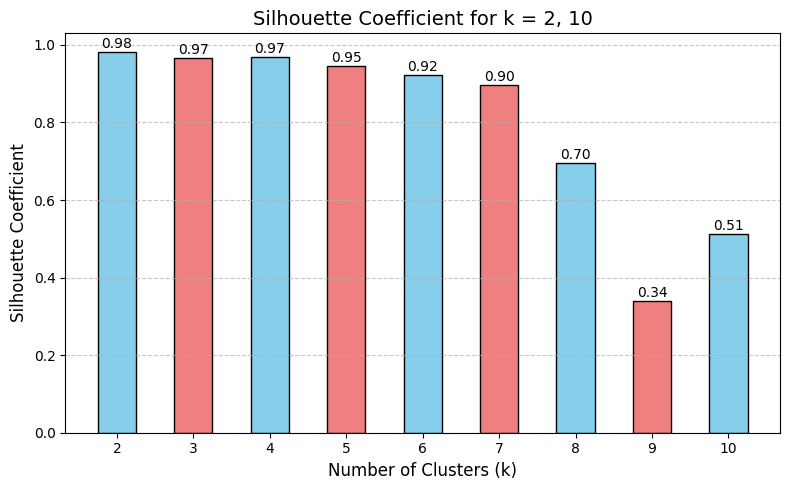

Optimal number of clusters (k): 2


In [9]:
import matplotlib.pyplot as plt
import numpy as np

feature_cols = ['Read Speed', 'Write Speed','Digital Storage Capacity (GB)','Memory Storage Capacity (GB)']

silhouette_list = []

for k in range(2,11):
    kmean = K_Mean(k)
    kmean.fit(df, feature_cols)
    df_fit = kmean.transform(df, feature_cols)
    evaluator = SilhouetteScore()
    silhouette_score = evaluator.evaluate(df_fit)
    silhouette_list.append(silhouette_score)

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
k_values = np.arange(2, 11)
# Draw the bar chart
colors = ['skyblue', 'lightcoral']  # Colors for the bars
bars = ax.bar(k_values, silhouette_list, color=colors, edgecolor='black', width=0.5)

# Set labels and title
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Coefficient', fontsize=12)
ax.set_title('Silhouette Coefficient for k = 2, 10', fontsize=14)
ax.set_xticks(k_values)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', fontsize=10)

# Customize grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

# Choose k with the highest Silhouette value
optimal_k = np.argmax(silhouette_list) + 2 # Add 2 because k starts from 2 in the loop
print(f"Optimal number of clusters (k): {optimal_k}")

In [10]:
feature_cols = ['Read Speed', 'Write Speed','Digital Storage Capacity (GB)','Memory Storage Capacity (GB)']
kmean = K_Mean(k=2)
kmean.fit(df,feature_cols)
df_fit = kmean.transform(df, feature_cols)
evaluator = SilhouetteScore()
silhouette_score = evaluator.evaluate(df_fit)
print(silhouette_score)

0.9807285882070823


In [11]:
df_fit.show(5)

df_tmp = df_fit.groupBy('prediction').count().orderBy('prediction')
df_tmp.show()

+--------------------+--------------------+--------------------+------------------+--------------------+---------+--------------------+-----------+-----------------------------+----------------------------+-----------+------------------------+-----------+--------------------+----------+
|               title|               price|           old_price|            rating|             reviews|purchases|          Read Speed|Write Speed|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|Color Index|Hardware Interface Index|Brand Index|            features|prediction|
+--------------------+--------------------+--------------------+------------------+--------------------+---------+--------------------+-----------+-----------------------------+----------------------------+-----------+------------------------+-----------+--------------------+----------+
|JSL JDTDC 256GB 3...|0.016664844556739288| 0.02036855495841464|0.9148936947312738|1.978833307176341...|      0.0|                 0.0| 

**Dùng thư viện máy học pyspark MLlib để so sánh với việc tự cài đặt**

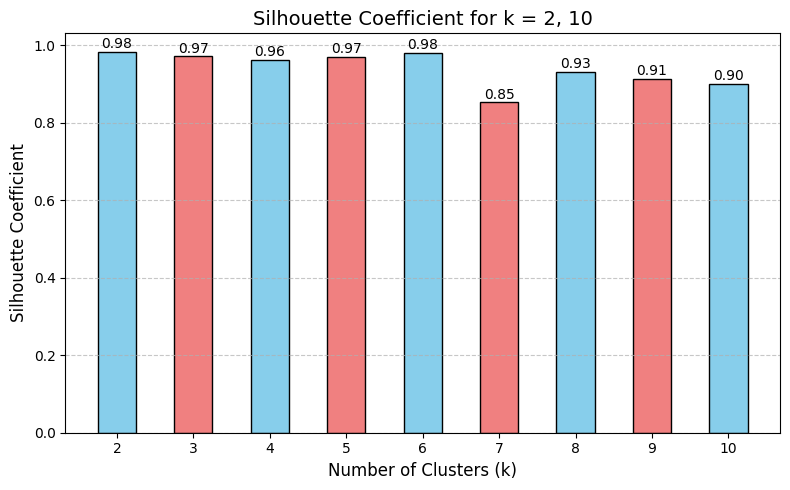

Optimal number of clusters (k): 2


In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các cột đầu vào
input_columns = ['Read Speed', 'Write Speed','Digital Storage Capacity (GB)','Memory Storage Capacity (GB)']

# Vector hóa các cột
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
vectorized_df = assembler.transform(df)

silhouette_list = []

for k in range(2,11):
    kmeans = KMeans(k=k, seed=1)
    kmeans = kmeans.setFeaturesCol("features")
    model = kmeans.fit(vectorized_df)
    df_result = model.transform(vectorized_df)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(df_result)
    silhouette_list.append(silhouette_score)

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
k_values = np.arange(2, 11)
# Draw the bar chart
colors = ['skyblue', 'lightcoral']  # Colors for the bars
bars = ax.bar(k_values, silhouette_list, color=colors, edgecolor='black', width=0.5)

# Set labels and title
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Coefficient', fontsize=12)
ax.set_title('Silhouette Coefficient for k = 2, 10', fontsize=14)
ax.set_xticks(k_values)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', fontsize=10)

# Customize grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

# Choose k with the highest Silhouette value
optimal_k = np.argmax(silhouette_list) + 2 # Add 2 because k starts from 2 in the loop
print(f"Optimal number of clusters (k): {optimal_k}")

In [13]:
kmeans = KMeans(k=2, seed=1)
kmeans = kmeans.setFeaturesCol("features")
model = kmeans.fit(vectorized_df)
clustered_df = model.transform(vectorized_df)
clustered_df.show(5)
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(clustered_df)
print(silhouette_score)
df_tmp = clustered_df.groupBy('prediction').count().orderBy('prediction')
df_tmp.show(5)

+--------------------+--------------------+--------------------+------------------+--------------------+---------+--------------------+-----------+-----------------------------+----------------------------+-----------+------------------------+-----------+--------------------+----------+
|               title|               price|           old_price|            rating|             reviews|purchases|          Read Speed|Write Speed|Digital Storage Capacity (GB)|Memory Storage Capacity (GB)|Color Index|Hardware Interface Index|Brand Index|            features|prediction|
+--------------------+--------------------+--------------------+------------------+--------------------+---------+--------------------+-----------+-----------------------------+----------------------------+-----------+------------------------+-----------+--------------------+----------+
|JSL JDTDC 256GB 3...|0.016664844556739288| 0.02036855495841464|0.9148936947312738|1.978833307176341...|      0.0|                 0.0| 